In [1]:
import os
import warnings
import logging
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.utils import resample

import config

np.random.seed(42)
logger = logging.getLogger()
warnings.filterwarnings("ignore")

In [254]:
matrix_subject_phases = os.path.join('..', 'features', 'matrix-2019-0226_15-16-44Features-157015.xlsx')
matrix_agent_phases = os.path.join('..', 'features', 'matrix-2019-0226_17-18-28Features-agent-157015.xlsx')
matrix_subject_nophase = os.path.join('..', 'features', 'matrix-2019-0227_20-11-53Features-nophase.xlsx')
matrix_agent_nophase = os.path.join('..', 'features', 'matrix-2019-0227_22-43-15Features-agent-nophase.xlsx') 

def prepare_df(df):
    df = df.drop(['Presence Score', 'Co-presence Score'], axis=1)
    df = df.rename(index=str,
                   columns={"Presence Class": "PresenceClass", "Co-presence Class": "CopresenceClass"})
    return df

def dfval(df, candidate, environment, column):
    return df.query("Candidate == '%s' & Environment == '%s'" % (candidate, environment))[column].values

print("Loading data - phases split ...")

subject_p_df = pd.read_excel(matrix_subject_phases)
subject_p_df = prepare_df(subject_p_df)
print("   Subject: %d samples" % len(subject_p_df))
agent_p_df = pd.read_excel(matrix_agent_phases)
agent_p_df = prepare_df(agent_p_df)
print("   Agent: %d samples" % len(agent_p_df))

all_p_df = pd.merge(subject_p_df, agent_p_df, on=['Candidate', 'Environment'], how='inner', suffixes=('', '_agent'))
all_p_df = all_p_df.drop(['PresenceClass_agent', 'CopresenceClass_agent', 'Duration_agent', 'Expert_agent'], axis=1)
print("   Merge: %d samples (common to subject and agent)" % len(all_p_df))

subject_p_df = pd.merge(subject_p_df, all_p_df, on=['Candidate', 'Environment'], how='inner', suffixes=('', '_toberemoved'))
subject_p_df = subject_p_df.drop([col for col in subject_p_df.columns if col.endswith('_toberemoved') ], axis=1)
print("   Subject merged check: %s" % len(subject_p_df))

agent_p_df = pd.merge(agent_p_df, all_p_df, on=['Candidate', 'Environment'], how='inner', suffixes=('', '_toberemoved'))
# computed duration is different for agent but this is due to how it's computed, let it be the same value as for subject
agent_p_df = agent_p_df.drop(['Duration'], axis=1)
agent_p_df = agent_p_df.rename(index=str, columns={'Duration_toberemoved': 'Duration'})
agent_p_df = agent_p_df.drop([col for col in agent_p_df.columns if col.endswith('_toberemoved')], axis=1)
print("   Agent merged check: %s" % len(agent_p_df))

# no phase

subject_np_df = pd.read_excel(matrix_subject_nophase)
subject_np_df = prepare_df(subject_np_df)
print("   Subject(no phase): %d samples" % len(subject_np_df))
agent_np_df = pd.read_excel(matrix_agent_nophase)
agent_np_df = prepare_df(agent_np_df)
print("   Agent(no phase): %d samples" % len(agent_np_df))

all_np_df = pd.merge(subject_np_df, agent_np_df, on=['Candidate', 'Environment'], how='inner', suffixes=('', '_agent'))
all_np_df = all_np_df.drop(['PresenceClass_agent', 'CopresenceClass_agent', 'Duration_agent', 'Expert_agent'], axis=1)
print("   Merge: %d samples (common to subject and agent)" % len(all_np_df))

subject_np_df = pd.merge(subject_np_df, all_np_df, on=['Candidate', 'Environment'], how='inner', suffixes=('', '_toberemoved'))
subject_np_df = subject_np_df.drop([col for col in subject_np_df.columns if col.endswith('_toberemoved') ], axis=1)
print("   Subject merged check: %s" % len(subject_np_df))

agent_np_df = pd.merge(agent_np_df, all_np_df, on=['Candidate', 'Environment'], how='inner', suffixes=('', '_toberemoved'))
# computed duration is different for agent but this is due to how it's computed, let it be the same value as for subject
agent_np_df = agent_np_df.drop(['Duration'], axis=1)
agent_np_df = agent_np_df.rename(index=str, columns={'Duration_toberemoved': 'Duration'})
agent_np_df = agent_np_df.drop([col for col in agent_np_df.columns if col.endswith('_toberemoved')], axis=1)
print("   Agent merged check: %s" % len(agent_np_df))

Loading data - phases split ...
   Subject: 83 samples
   Agent: 95 samples
   Merge: 81 samples (common to subject and agent)
   Subject merged check: 81
   Agent merged check: 81
   Subject(no phase): 86 samples
   Agent(no phase): 92 samples
   Merge: 81 samples (common to subject and agent)
   Subject merged check: 81
   Agent merged check: 81


In [ ]:
# todo "Avg_IPUlen_Begin", "Avg_IPUlen_Middle", "Avg_IPUlen_End" removed because of wrong values
subject_features = ("Expert", "Head_Entropy_Start", "Head_Entropy_Mid", "Head_Entropy_End", "Avg_HandEntropy_Begin",
             "Avg_HandEntropy_Mid", "Avg_HandEntropy_End", "Avg_SentenceLength_Begin", "Avg_SentenceLength_Mid",
             "Avg_SentenceLength_End",  "Ratio1_Begin", "Ratio1_Mid", "Ratio1_End", "Ratio2_Begin", "Ratio2_Mid", 
                    "Ratio2_End", "Duration")

# not using "Expert" feature for agent features
agent_features = ("Head_Entropy_Start", "Head_Entropy_Mid", "Head_Entropy_End", "Avg_HandEntropy_Begin",
             "Avg_HandEntropy_Mid", "Avg_HandEntropy_End", "Avg_SentenceLength_Begin", "Avg_SentenceLength_Mid",
             "Avg_SentenceLength_End",  "Ratio1_Begin", "Ratio1_Mid", "Ratio1_End", "Ratio2_Begin", "Ratio2_Mid", 
                    "Ratio2_End", "Duration")

all_features = subject_features + tuple(feat+'_agent' for feat in agent_features if feat is not 'Duration')
print(all_features)

subject_features_nophase = ("Expert", "Head_Entropy_Mid", "Avg_HandEntropy_Mid", "Avg_SentenceLength_Mid", "Ratio1_Mid", 
                            "Ratio2_Mid", "Duration")

agent_features_nophase = ("Head_Entropy_Mid", "Avg_HandEntropy_Mid", "Avg_SentenceLength_Mid", "Ratio1_Mid", 
                            "Ratio2_Mid", "Duration")

all_features_nophase = subject_features_nophase + tuple(feat+'_agent' for feat in agent_features if feat is not 'Duration')
print(all_features_nophase)

out_path = os.path.join(config.OUT_PATH, 'gridsearchcv')
if not os.path.exists(out_path): os.makedirs(out_path)

def gscv_name(presence=True, doctor=True, agent=False, phases=None, classifier='RF'):
    pres = 'presence' if presence else 'copresence'
    subject = 'doctor' if doctor else ''
    subject = subject + ('agent' if agent else '')
    ph = 'nophase' if phases is None else '%d%d%d' % ( phases[0]*100, phases[1]*100, phases[2]*100 )
    return "%s_%s_%s_%s" % (pres, subject, ph, classifier)

def save_gscv(grid, presence=True, doctor=True, agent=False, phases=None, classifier='RF'):
    name = "grid_%s.pkl" % (gscv_name(presence, doctor, agent, phases, classifier))
    f = open(os.path.join(out_path, name), 'wb')
    pickle.dump(grid, f)
    f.close()
    
def load_gscv(presence=True, doctor=True, phases=None, classifier='RF'):
    name = "grid_%s.pkl" % (gscv_name(presence, doctor, agent, phases, classifier))
    f = open(os.path.join(out_path, name), 'rb')
    grid = pickle.load(f)
    f.close()
    return grid

def save_results(rdf):
    try:
        frdf_name = 'results.pkl'
        frdf = open(os.path.join(out_path, frdf_name), 'wb')
        pickle.dump(rdf, frdf)
        frdf.close()
    except Exception as e:
        print('Could not save results file %s' % (os.path.join(out_path, frdf_name)))
        print(e)
        return False
    return True

def load_results():
    try:
        frdf_name = 'results.pkl'
        frdf = open(os.path.join(out_path, frdf_name), 'rb')
        rdf = pickle.load(frdf)
        frdf.close()
    except Exception:
        print('results file does not yet exist')
        return None
    return rdf

def gridsearch(clf, samples, modelTarget, param_grid, features, upsample=False):
    #print("gridsearch(clf=%s, modelTarget=%s, param_grid=%s, features=%s, upsample=%s)" 
    #      % (type(clf), modelTarget, param_grid, features, upsample))

    names = features

    samples_split = []
    if (modelTarget == "presence"):
        samples_split.append(samples[samples.PresenceClass == 1])
        samples_split.append(samples[samples.PresenceClass == 2])
        samples_split.append(samples[samples.PresenceClass == 3])

    elif (modelTarget == "copresence"):
        samples_split.append(samples[samples.CopresenceClass == 1])
        samples_split.append(samples[samples.CopresenceClass == 2])
        samples_split.append(samples[samples.CopresenceClass == 3])
    else:
        sys.exit("Invalid input. Please pick between presence and copresence")

    maxClassSize = max(samples_split[0].shape[0], samples_split[1].shape[0], samples_split[2].shape[0])

    if upsample:
        upsampled = []
        # todo upsample with SMOTE algorithm ? https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SMOTE.html
        for idx, samples in enumerate(samples_split):
            if (samples.shape[0] == maxClassSize):
                upsampled.append(samples)
            else:
                logger.debug("resample: adding " + str(maxClassSize - samples.shape[0]) + " samples to class " + str(
                    idx + 1) + " to reach " + str(maxClassSize))
                upsampled.append(resample(samples, replace=True, n_samples=maxClassSize, random_state=None))

        balanced_set = pd.concat(upsampled)
        X = np.nan_to_num(balanced_set.as_matrix(names))

        if (modelTarget == "presence"):
            y = np.array(balanced_set["PresenceClass"].tolist())

        else:
            y = np.array(balanced_set["CopresenceClass"].tolist())

    else:

        X = np.nan_to_num(samples[list(names)])
        if modelTarget == "presence":
            y = samples.PresenceClass
        else:
            y = samples.CopresenceClass

    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    #logger.debug("X_train ", X_train.shape, "X_test", X_test.shape, "y_train", y_train.shape, "y_test", y_test.shape)

  # todo move to beginning with other imports

    #n_estimators = np.concatenate((np.arange(1,10), np.arange(10,100,10)))

    grid = GridSearchCV(estimator=clf, param_grid=param_grid,
                        scoring=['f1_macro', 'precision_macro', 'recall_macro'],
                        refit='precision_macro',
                        cv=10,
                        return_train_score=True,
                        verbose=1,
                        n_jobs=-1)

    grid = grid.fit(X, y)

    results = grid.cv_results_
    # print("best params ", grid.best_params_)
    # print("best score ", grid.best_score_)

    return grid

In [ ]:
# prepare results
rdf_index = [['Presence', 'Co-Presence'], ['Doctor', 'Agent', 'Doctor+Agent'], ['No Phase', '157015'], ['Random Forests', 'SVM']]
rdf_columns = ['precision', 'f1', 'recall', 'params']
rdf_multiindex = pd.MultiIndex.from_product(rdf_index, names=['Metric', 'Subject', 'Phases', 'Classifier'])

rdf = load_results()
if rdf is None:
    rdf = pd.DataFrame(np.zeros((24,4)), index=rdf_multiindex, columns=rdf_columns)
    rdf['params'] = rdf['params'].apply(str)
    rdf['params'] = ''
    save_results(rdf)
rdf

In [ ]:
# Global parameters

# random forests
n_estimators = [10]#, 20, 30, 40, 50, 100, 1000]
class_weights = [None, 'balanced', 'balanced_subsample']
max_features = [None, 'auto', 'sqrt', 'log2']
param_grid =  {
    'n_estimators': n_estimators,
    'class_weight': class_weights,
    'max_features': max_features
}

# SVM
Cs = np.logspace(-2, 10, 5)
gammas = np.logspace(-9, 3, 5)
kernels = ['linear', 'rbf', 'poly', 'sigmoid']
param_grid_svm = {
    'kernel': kernels,
    'C': Cs,
    'gamma': gammas
}

def update_results(cv_results_, rdf, p1, p2, p3, p4):
    df = pd.DataFrame(cv_results_)
    best_precision = df.mean_test_precision_macro.max()
    df_best = df.loc[df['mean_test_precision_macro'] == best_precision]
    rdf.at[(p1, p2, p3, p4), 'precision'] = df_best.mean_test_precision_macro.values[0]
    rdf.at[(p1, p2, p3, p4), 'f1'] = df_best.mean_test_f1_macro.values[0]
    rdf.at[(p1, p2, p3, p4), 'recall'] = df_best.mean_test_recall_macro.values[0]
    rdf.at[(p1, p2, p3, p4), 'params'] = str(df_best.params.values[0])
    #print("%s %s %s %s %s" % (p1, p2, p3, p4, str(rdf.at[p1, p2, p3, p4])))
    save_results(rdf)
    return rdf

forest = RandomForestClassifier(random_state=42)
svm = SVC(random_state=42)

In [ ]:
# combinations to be ran
from sklearn.model_selection import ParameterGrid
test_plan_params = {
    'classifier': ['svm'],
    'subject': ['doctor', 'agent', 'doctor+agent'],
    'target': ['presence', 'copresence'],
    'phases': [(0.15,0.70,0.15), (0,1,0)]
}
test_plan = list(ParameterGrid(test_plan_params))

# Test Plan

In [ ]:
for idx, test in enumerate(test_plan):
    print("Test %d : %s" % (idx, test))

    subject = test['subject']
    target = test['target']
    phases = test['phases']
    classifier = test['classifier']
    clf = forest if classifier == 'forest' else svm
    pgrid = param_grid if classifier == 'forest' else param_grid_svm

    if phases is not None and phases is not (0,1,0):
        if subject == 'doctor':
            df = subject_p_df
            feats = subject_features
        elif subject == 'agent':
            df = agent_p_df
            feats = agent_features
        elif subject == 'doctor+agent':
            df = all_p_df
            feats=all_features
    else:
        if subject == 'doctor':
            df = subject_np_df
            feats = subject_features_nophase
        elif subject == 'agent':
            df = agent_np_df
            feats = agent_features_nophase
        elif subject == 'doctor+agent':
            df = all_np_df
            feats=all_features_nophase   
    
    grid = gridsearch(clf, df, target, param_grid=pgrid, features=feats, upsample=True)
    
    isDoc = 'doctor' in subject
    isAgent = 'agent' in subject
    save_gscv(grid, presence=target=='presence', doctor=isDoc, agent=isAgent,
             phases=phases, classifier='RF' if test['classifier']=='forest' else 'SVM')
    
    presidx = 'Presence' if target == 'presence' else 'Co-Presence'
    if subject == 'doctor':
        subjidx = 'Doctor'
    elif subject == 'agent':
        subjidx = 'Agent'
    else:
        subjidx = 'Doctor+Agent'
    phidx = 'No Phase' if phases in [None, (0,1,0)] else '%2d%2d%2d' % ( phases[0]*100, phases[1]*100, phases[2]*100 )
    clfidx = 'Random Forests' if classifier == 'forest' else 'SVM'
    print("      updating %s %s %s %s" % (presidx, subjidx, phidx, clfidx))
    rdf = update_results(grid.cv_results_, rdf, presidx, subjidx, phidx, clfidx)
    dumpPath = os.path.join(config.OUT_PATH, 'gridsearchcv', 'results.xlsx')
    rdf.to_excel(dumpPath, index=True)

In [174]:
grid = gridsearch(forest, subject_p_df, 'presence', param_grid=param_grid, features=subject_features, upsample=True)
save_gscv(grid, presence=True, doctor=True, agent=False, phases=(0.15,0.70,0.15), classifier='RF')
rdf = update_results(grid.cv_results_, rdf, 'Presence', 'Doctor', '157015', 'Random Forests')

gridsearch(clf=<class 'sklearn.ensemble.forest.RandomForestClassifier'>, modelTarget=presence, param_grid={'n_estimators': [10, 20, 30, 40, 50, 100, 1000], 'max_features': [None, 'auto', 'sqrt', 'log2'], 'class_weight': [None, 'balanced', 'balanced_subsample']}, features=('Expert', 'Head_Entropy_Start', 'Head_Entropy_Mid', 'Head_Entropy_End', 'Avg_HandEntropy_Begin', 'Avg_HandEntropy_Mid', 'Avg_HandEntropy_End', 'Avg_SentenceLength_Begin', 'Avg_SentenceLength_Mid', 'Avg_SentenceLength_End', 'Ratio1_Begin', 'Ratio1_Mid', 'Ratio1_End', 'Ratio2_Begin', 'Ratio2_Mid', 'Ratio2_End', 'Duration'), upsample=True)
presence random forest
Fitting 10 folds for each of 84 candidates, totalling 840 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 840 out of 840 | elapsed:  5.3min finished


In [ ]:
grid = gridsearch(svm, subject_p_df, 'presence', param_grid=param_grid_svm, features=subject_features, upsample=True)
save_gscv(grid, presence=True, doctor=True, agent=False, phases=(0.15,0.70,0.15), classifier='SVM')
rdf = update_results(grid.cv_results_, rdf, 'Presence', 'Doctor', '157015', 'Random Forests')

## Agent + phases split(0.15, 0.70, 0.15)

In [157]:
grid = randomForest_gridsearch(agent_p_df, 'presence', param_grid=param_grid, features=agent_features, upsample=True)
save_gscv(grid, presence=True, doctor=False, agent = True, phases=(0.15,0.70,0.15), classifier='RF')

randomForest_gridsearch(modelTarget=presence, param_grid={'n_estimators': [10, 20, 30, 40, 50, 100, 1000], 'max_features': [None, 'auto', 'sqrt', 'log2'], 'class_weight': [None, 'balanced', 'balanced_subsample']}, features=('Head_Entropy_Start', 'Head_Entropy_Mid', 'Head_Entropy_End', 'Avg_HandEntropy_Begin', 'Avg_HandEntropy_Mid', 'Avg_HandEntropy_End', 'Avg_SentenceLength_Begin', 'Avg_SentenceLength_Mid', 'Avg_SentenceLength_End', 'Ratio1_Begin', 'Ratio1_Mid', 'Ratio1_End', 'Ratio2_Begin', 'Ratio2_Mid', 'Ratio2_End', 'Duration'), upsample=True)
presence random forest
Fitting 10 folds for each of 84 candidates, totalling 840 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 840 out of 840 | elapsed:  4.9min finished


In [158]:
rdf = update_results(grid.cv_results_, rdf, 'Presence', 'Agent', '157015', 'Random Forests')

precision        f1  \
Metric      Subject      Phases   Classifier                            
Presence    Doctor       No Phase Random Forests   0.000000  0.000000   
                                  SVM              0.000000  0.000000   
                         157015   Random Forests   0.896508  0.852215   
                                  SVM              0.000000  0.000000   
            Agent        No Phase Random Forests   0.000000  0.000000   
                                  SVM              0.000000  0.000000   
                         157015   Random Forests   0.798254  0.762850   
                                  SVM              0.000000  0.000000   
            Doctor+Agent No Phase Random Forests   0.000000  0.000000   
                                  SVM              0.000000  0.000000   
                         157015   Random Forests   0.784127  0.757657   
                                  SVM              0.000000  0.000000   
Co-Presence Doctor       No Phase Random Forests   0.000000  0.000000   
                                  SVM              0.000000  0.000000   
                         157015   Random Forests   0.000000  0.000000   
                                  SVM              0.000000  0.000000   
            Agent        No Phase Random Forests   0.000000  0.000000   
                                  SVM              0.000000  0.000000   
                         157015   Random Forests   0.000000  0.000000   
                                  SVM              0.000000  0.000000   
            Doctor+Agent No Phase Random Forests   0.000000  0.000000   
                                  SVM              0.000000  0.000000   
                         157015   Random Forests   0.000000  0.000000   
                                  SVM              0.000000  0.000000   

                                                    recall  \
Metric      Subject      Phases   Classifier                 
Presence    Doctor       No Phase Random Forests  0.000000   
                                  SVM             0.000000   
                         157015   Random Forests  0.857143   
                                  SVM             0.000000   
            Agent        No Phase Random Forests  0.000000   
                                  SVM             0.000000   
                         157015   Random Forests  0.771429   
                                  SVM             0.000000   
            Doctor+Agent No Phase Random Forests  0.000000   
                                  SVM             0.000000   
                         157015   Random Forests  0.771429   
                                  SVM             0.000000   
Co-Presence Doctor       No Phase Random Forests  0.000000   
                                  SVM             0.000000   
                         157015   Random Forests  0.000000   
                                  SVM             0.000000   
            Agent        No Phase Random Forests  0.000000   
                                  SVM             0.000000   
                         157015   Random Forests  0.000000   
                                  SVM             0.000000   
            Doctor+Agent No Phase Random Forests  0.000000   
                                  SVM             0.000000   
                         157015   Random Forests  0.000000   
                                  SVM             0.000000   

                                                                                             params  
Metric      Subject      Phases   Classifier                                                         
Presence    Doctor       No Phase Random Forests                                                     
                                  SVM                                                                
                         157015   Random Forests  {'max_features': 'auto', 'n_estimators': 40, '...  
                            

## Subject + no phase split

## Agent + no phase split

## Subject + Agent + phases split (0.15, 0.70, 0.15)

In [159]:
grid = randomForest_gridsearch(all_p_df, 'presence', param_grid=param_grid, features=all_features, upsample=True)
save_gscv(grid, presence=True, doctor=True, agent=True, phases=(0.15,0.70,0.15), classifier='RF')

rdf = update_results(grid.cv_results_, rdf, 'Presence', 'Doctor+Agent', '157015', 'Random Forests')

randomForest_gridsearch(modelTarget=presence, param_grid={'n_estimators': [10, 20, 30, 40, 50, 100, 1000], 'max_features': [None, 'auto', 'sqrt', 'log2'], 'class_weight': [None, 'balanced', 'balanced_subsample']}, features=('Expert', 'Head_Entropy_Start', 'Head_Entropy_Mid', 'Head_Entropy_End', 'Avg_HandEntropy_Begin', 'Avg_HandEntropy_Mid', 'Avg_HandEntropy_End', 'Avg_SentenceLength_Begin', 'Avg_SentenceLength_Mid', 'Avg_SentenceLength_End', 'Ratio1_Begin', 'Ratio1_Mid', 'Ratio1_End', 'Ratio2_Begin', 'Ratio2_Mid', 'Ratio2_End', 'Duration', 'Head_Entropy_Start_agent', 'Head_Entropy_Mid_agent', 'Head_Entropy_End_agent', 'Avg_HandEntropy_Begin_agent', 'Avg_HandEntropy_Mid_agent', 'Avg_HandEntropy_End_agent', 'Avg_SentenceLength_Begin_agent', 'Avg_SentenceLength_Mid_agent', 'Avg_SentenceLength_End_agent', 'Ratio1_Begin_agent', 'Ratio1_Mid_agent', 'Ratio1_End_agent', 'Ratio2_Begin_agent', 'Ratio2_Mid_agent', 'Ratio2_End_agent'), upsample=True)
presence random forest
Fitting 10 folds for ea

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 840 out of 840 | elapsed:  5.1min finished


precision        f1  \
Metric      Subject      Phases   Classifier                            
Presence    Doctor       No Phase Random Forests   0.000000  0.000000   
                                  SVM              0.000000  0.000000   
                         157015   Random Forests   0.896508  0.852215   
                                  SVM              0.000000  0.000000   
            Agent        No Phase Random Forests   0.000000  0.000000   
                                  SVM              0.000000  0.000000   
                         157015   Random Forests   0.798254  0.762850   
                                  SVM              0.000000  0.000000   
            Doctor+Agent No Phase Random Forests   0.000000  0.000000   
                                  SVM              0.000000  0.000000   
                         157015   Random Forests   0.856372  0.784093   
                                  SVM              0.000000  0.000000   
Co-Presence Doctor       No Phase Random Forests   0.000000  0.000000   
                                  SVM              0.000000  0.000000   
                         157015   Random Forests   0.000000  0.000000   
                                  SVM              0.000000  0.000000   
            Agent        No Phase Random Forests   0.000000  0.000000   
                                  SVM              0.000000  0.000000   
                         157015   Random Forests   0.000000  0.000000   
                                  SVM              0.000000  0.000000   
            Doctor+Agent No Phase Random Forests   0.000000  0.000000   
                                  SVM              0.000000  0.000000   
                         157015   Random Forests   0.000000  0.000000   
                                  SVM              0.000000  0.000000   

                                                    recall  \
Metric      Subject      Phases   Classifier                 
Presence    Doctor       No Phase Random Forests  0.000000   
                                  SVM             0.000000   
                         157015   Random Forests  0.857143   
                                  SVM             0.000000   
            Agent        No Phase Random Forests  0.000000   
                                  SVM             0.000000   
                         157015   Random Forests  0.771429   
                                  SVM             0.000000   
            Doctor+Agent No Phase Random Forests  0.000000   
                                  SVM             0.000000   
                         157015   Random Forests  0.800000   
                                  SVM             0.000000   
Co-Presence Doctor       No Phase Random Forests  0.000000   
                                  SVM             0.000000   
                         157015   Random Forests  0.000000   
                                  SVM             0.000000   
            Agent        No Phase Random Forests  0.000000   
                                  SVM             0.000000   
                         157015   Random Forests  0.000000   
                                  SVM             0.000000   
            Doctor+Agent No Phase Random Forests  0.000000   
                                  SVM             0.000000   
                         157015   Random Forests  0.000000   
                                  SVM             0.000000   

                                                                                             params  
Metric      Subject      Phases   Classifier                                                         
Presence    Doctor       No Phase Random Forests                                                     
                                  SVM                                                                
                         157015   Random Forests  {'max_features': 'auto', 'n_estimators': 40, '...  
                            

In [ ]:
grid = randomForest_gridsearch(all_p_df, 'presence', param_grid=param_grid, features=all_features, upsample=True)
save_gscv(grid, presence=True, doctor=True, agent=True, phases=(0.15,0.70,0.15), classifier='RF')

rdf = update_results(grid.cv_results_, rdf, 'Presence', 'Doctor+Agent', '157015', 'Random Forests')

## Subject + Agent + no phase split

# Results summary

In [162]:
dumpPath = os.path.join(config.OUT_PATH, 'gridsearchcv', 'results.xlsx')
rdf.to_excel(dumpPath, index=True)
rdf

precision        f1  \
Metric      Subject      Phases   Classifier                            
Presence    Doctor       No Phase Random Forests   0.000000  0.000000   
                                  SVM              0.000000  0.000000   
                         157015   Random Forests   0.896508  0.852215   
                                  SVM              0.000000  0.000000   
            Agent        No Phase Random Forests   0.000000  0.000000   
                                  SVM              0.000000  0.000000   
                         157015   Random Forests   0.798254  0.762850   
                                  SVM              0.000000  0.000000   
            Doctor+Agent No Phase Random Forests   0.000000  0.000000   
                                  SVM              0.000000  0.000000   
                         157015   Random Forests   0.856372  0.784093   
                                  SVM              0.000000  0.000000   
Co-Presence Doctor       No Phase Random Forests   0.000000  0.000000   
                                  SVM              0.000000  0.000000   
                         157015   Random Forests   0.000000  0.000000   
                                  SVM              0.000000  0.000000   
            Agent        No Phase Random Forests   0.000000  0.000000   
                                  SVM              0.000000  0.000000   
                         157015   Random Forests   0.000000  0.000000   
                                  SVM              0.000000  0.000000   
            Doctor+Agent No Phase Random Forests   0.000000  0.000000   
                                  SVM              0.000000  0.000000   
                         157015   Random Forests   0.000000  0.000000   
                                  SVM              0.000000  0.000000   

                                                    recall  \
Metric      Subject      Phases   Classifier                 
Presence    Doctor       No Phase Random Forests  0.000000   
                                  SVM             0.000000   
                         157015   Random Forests  0.857143   
                                  SVM             0.000000   
            Agent        No Phase Random Forests  0.000000   
                                  SVM             0.000000   
                         157015   Random Forests  0.771429   
                                  SVM             0.000000   
            Doctor+Agent No Phase Random Forests  0.000000   
                                  SVM             0.000000   
                         157015   Random Forests  0.800000   
                                  SVM             0.000000   
Co-Presence Doctor       No Phase Random Forests  0.000000   
                                  SVM             0.000000   
                         157015   Random Forests  0.000000   
                                  SVM             0.000000   
            Agent        No Phase Random Forests  0.000000   
                                  SVM             0.000000   
                         157015   Random Forests  0.000000   
                                  SVM             0.000000   
            Doctor+Agent No Phase Random Forests  0.000000   
                                  SVM             0.000000   
                         157015   Random Forests  0.000000   
                                  SVM             0.000000   

                                                                                             params  
Metric      Subject      Phases   Classifier                                                         
Presence    Doctor       No Phase Random Forests                                                     
                                  SVM                                                                
                         157015   Random Forests  {'max_features': 'auto', 'n_estimators': 40, '...  
                            

## Specific tests on 'Expert' feature

In [235]:
# specific test on expert importance

subject_features = ("Expert", "Head_Entropy_Start", "Head_Entropy_Mid", "Head_Entropy_End", "Avg_HandEntropy_Begin",
             "Avg_HandEntropy_Mid", "Avg_HandEntropy_End", "Avg_SentenceLength_Begin", "Avg_SentenceLength_Mid",
             "Avg_SentenceLength_End",  "Ratio1_Begin", "Ratio1_Mid", "Ratio1_End", "Ratio2_Begin", "Ratio2_Mid", 
                    "Ratio2_End", "Duration")

subject_noexpert_features = ("Head_Entropy_Start", "Head_Entropy_Mid", "Head_Entropy_End", "Avg_HandEntropy_Begin",
             "Avg_HandEntropy_Mid", "Avg_HandEntropy_End", "Avg_SentenceLength_Begin", "Avg_SentenceLength_Mid",
             "Avg_SentenceLength_End",  "Ratio1_Begin", "Ratio1_Mid", "Ratio1_End", "Ratio2_Begin", "Ratio2_Mid", 
                    "Ratio2_End", "Duration")

# not using "Expert" feature for agent features
agent_features = ("Head_Entropy_Start", "Head_Entropy_Mid", "Head_Entropy_End", "Avg_HandEntropy_Begin",
             "Avg_HandEntropy_Mid", "Avg_HandEntropy_End", "Avg_SentenceLength_Begin", "Avg_SentenceLength_Mid",
             "Avg_SentenceLength_End",  "Ratio1_Begin", "Ratio1_Mid", "Ratio1_End", "Ratio2_Begin", "Ratio2_Mid", 
                    "Ratio2_End", "Duration")

In [236]:
grid1 = gridsearch(forest, subject_p_df, 'presence', param_grid=param_grid, features=subject_features, upsample=True)
df = pd.DataFrame(grid1.cv_results_)
best_precision = df.mean_test_precision_macro.max()
df_best_1 = pd.DataFrame(df.loc[df['mean_test_precision_macro'] == best_precision])
df_best_1 = pd.DataFrame(df_best_1.values, index=['Doctor / Expert'], columns=df_best_1.columns)

Fitting 10 folds for each of 84 candidates, totalling 840 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 840 out of 840 | elapsed:  5.2min finished


TypeError: Index(...) must be called with a collection of some kind, '' was passed

In [242]:
df = pd.DataFrame(grid1.cv_results_)
best_precision = df.mean_test_precision_macro.max()
df_best_1 = pd.DataFrame(df.loc[df['mean_test_precision_macro'] == best_precision])
df_best_1 = pd.DataFrame(df_best_1.values, index=['Doctor / Expert'], columns=df_best_1.columns)

In [238]:
grid2 = gridsearch(forest, subject_p_df, 'presence', param_grid=param_grid, features=subject_noexpert_features, upsample=True)
df = pd.DataFrame(grid2.cv_results_)
best_precision = df.mean_test_precision_macro.max()
df_best_2 = pd.DataFrame(df.loc[df['mean_test_precision_macro'] == best_precision])
df_best_2 = pd.DataFrame(df_best_2.values, index=['Doctor / No Expert'], columns=df_best_1.columns)

Fitting 10 folds for each of 84 candidates, totalling 840 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 840 out of 840 | elapsed:  5.4min finished


In [239]:
grid3 = gridsearch(forest, agent_p_df, 'presence', param_grid=param_grid, features=agent_features, upsample=True)
df = pd.DataFrame(grid3.cv_results_)
best_precision = df.mean_test_precision_macro.max()
df_best_3 = pd.DataFrame(df.loc[df['mean_test_precision_macro'] == best_precision])
df_best_3 = pd.DataFrame(df_best_3.values, index=['Agent / No Expert'], columns=df_best_1.columns)

Fitting 10 folds for each of 84 candidates, totalling 840 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 840 out of 840 | elapsed:  5.1min finished


In [246]:
df_best_all = pd.concat([df_best_1, df_best_2, df_best_3])
df_best_all[['mean_test_precision_macro', 'mean_test_f1_macro', 'mean_test_recall_macro', 'params']]

,mean_test_precision_macro,mean_test_f1_macro,mean_test_recall_macro,params
Doctor / Expert,0.863175,0.840695,0.847619,"{u'max_features': u'auto', u'n_estimators': 20..."
Doctor / No Expert,0.84127,0.823568,0.828571,"{u'max_features': u'log2', u'n_estimators': 10..."
Agent / No Expert,0.861927,0.800306,0.809524,"{u'max_features': u'log2', u'n_estimators': 10..."


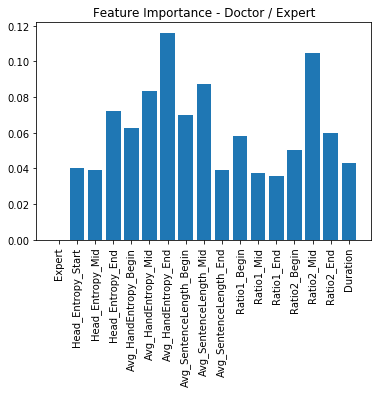

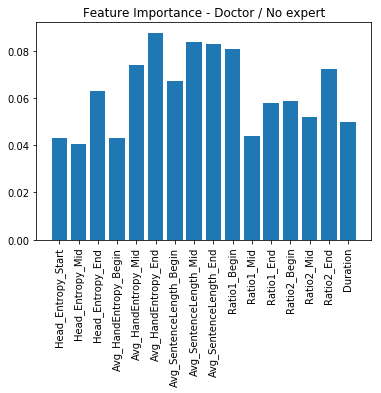

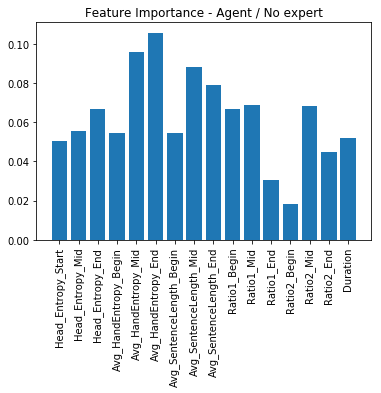

In [247]:
def plot_importance(title, importances, feature_names, sort=True):
    # Sort feature importances in descending order
    if sort:
        indices = np.argsort(importances)[::-1]
    else:
        indices = np.arange(len(feature_names))

    # Rearrange feature names so they match the sorted feature importances
    names = [feature_names[i] for i in indices]

    # Create plot
    plt.figure()

    # Create plot title
    plt.title("Feature Importance - " + title)

    # Add bars
    plt.bar(range(len(feature_names)), importances[indices])

    # Add feature names as x-axis labels
    plt.xticks(range(len(feature_names)), names, rotation=90)

    # Show plot
    plt.show()
    
plot_importance('Doctor / Expert', grid1.best_estimator_.feature_importances_, subject_features, sort=False)
plot_importance('Doctor / No expert', grid2.best_estimator_.feature_importances_, subject_noexpert_features, sort=False)
plot_importance('Agent / No expert', grid3.best_estimator_.feature_importances_, agent_features, sort=False)

In [249]:
import numpy as np, scipy.stats as st

def confint(a):
    return st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))

a = [1, 1.1, 0.9, 1.15, 0.8, 1.03, 0.99]
print(confint(a))

(0.8866952590268444, 1.1047333124017271)
